# XGboost

In [1]:
import pandas as pd
import os
import random
import numpy as np

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # data 경로 지정
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path, parse_dates=["Timestamp"]) 

## 2. Feature Engineering

In [3]:
from feature_engineering import get_features

df = get_features(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,correct_shift_-2,...,relative_time,test_mean,test_sum,tag_mean,tag_sum,assess_mean,assess_sum,user_mean,user_sum,correct_per_hour
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,1.0,...,-27.0,0.947683,1268,0.955022,637,0.982063,219,0.630872,470,0.649446
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,1.0,...,-24.0,0.947683,1268,0.913187,3040,0.964126,215,0.630872,470,0.649446
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,1.0,...,-19.0,0.947683,1268,0.913187,3040,0.910314,203,0.630872,470,0.649446
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.968610,216,0.630872,470,0.649446
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.0,...,-20.0,0.947683,1268,0.913187,3040,0.941704,210,0.630872,470,0.649446


## 3. Train/Test 데이터 셋 분리

In [4]:
from util import setSeeds, custom_train_test_split, get_eval

setSeeds(42)

# 유저별 분리
train, test = custom_train_test_split(df, ratio=0.99)

In [5]:
# 사용할 Feature 설정

cate_cols=[#"assessmentItemID", 
           #"testId", 
           "KnowledgeTag", 
           "correct_shift_-2", 
           "correct_shift_-1", 
           "correct_shift_1", 
           "correct_shift_2",
           #"hour", 
           "hour_mode",                 
           ]
    
cont_cols=["user_acc", 
           #"user_correct_answer", 
           #"user_total_answer", 
           #"future_correct", 
           "average_content_correct", 
           "mean_time", 
           #"time_median",
           #"correct_per_hour", 
           "time", 
           #"normalized_time",
           #"relative_time", 
           "assess_mean", 
           "assess_sum", 
           "tag_mean", 
           "tag_sum", 
           "test_mean", 
           "test_sum",
           "user_mean",
           #"user_sum",
           ]
           
FEATS = cate_cols + cont_cols

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [6]:
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,correct_shift_-2,correct_shift_-1,...,relative_time,test_mean,test_sum,tag_mean,tag_sum,assess_mean,assess_sum,user_mean,user_sum,correct_per_hour
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,1.0,1.0,...,-27.0,0.947683,1268,0.955022,637,0.982063,219,0.630872,470,0.649446
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1.0,1,1.000000,1.0,1.0,...,-24.0,0.947683,1268,0.913187,3040,0.964126,215,0.630872,470,0.649446
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2.0,2,1.000000,1.0,1.0,...,-19.0,0.947683,1268,0.913187,3040,0.910314,203,0.630872,470,0.649446
3,0,A060001004,A060000001,2020-03-24 00:17:29,7225,3.0,3,1.000000,1.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.968610,216,0.630872,470,0.649446
4,0,A060001005,A060000001,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.941704,210,0.630872,470,0.649446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,2020-06-05 06:50:21,438,1.0,4,0.250000,1.0,1.0,...,-16.0,0.662590,921,0.689706,2814,0.435252,121,0.555556,5,0.629941
2266582,7441,A040165001,A040000165,2020-08-21 01:06:39,8836,1.0,5,0.200000,1.0,1.0,...,6632138.0,0.655109,718,0.697874,2199,0.649635,178,0.555556,5,0.644321
2266583,7441,A040165002,A040000165,2020-08-21 01:06:50,8836,2.0,6,0.333333,1.0,1.0,...,-29.0,0.655109,718,0.697874,2199,0.635036,174,0.555556,5,0.644321
2266584,7441,A040165003,A040000165,2020-08-21 01:07:36,8836,3.0,7,0.428571,NaN,1.0,...,6.0,0.655109,718,0.697874,2199,0.791971,217,0.555556,5,0.644321


## 4. 훈련 및 검증

In [7]:
#!pip install xgboost

In [8]:
import xgboost as xgb

xgb_train = xgb.DMatrix(data=train[FEATS] , label=y_train)
xgb_test = xgb.DMatrix(data=test[FEATS] , label=y_test)

In [9]:
params = {'eta': 0.01,
          'booster': 'dart',
          'objective':'binary:logistic',
          'eval_metric':'auc',
	 }
num_rounds = 100
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(xgb_train,'train'),(xgb_test,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=xgb_train , num_boost_round=num_rounds , evals=wlist )

pred_probs = xgb_model.predict(xgb_test)

get_eval(y_test, np.where(pred_probs>=0.5, 1, 0))

[0]	train-auc:0.82963	eval-auc:0.82031
[1]	train-auc:0.82987	eval-auc:0.81696
[2]	train-auc:0.83051	eval-auc:0.81585
[3]	train-auc:0.83120	eval-auc:0.81417
[4]	train-auc:0.83130	eval-auc:0.81417
[5]	train-auc:0.83162	eval-auc:0.81417
[6]	train-auc:0.83181	eval-auc:0.81138
[7]	train-auc:0.83231	eval-auc:0.80525
[8]	train-auc:0.83253	eval-auc:0.80692
[9]	train-auc:0.83269	eval-auc:0.80971
[10]	train-auc:0.83316	eval-auc:0.80971
[11]	train-auc:0.83336	eval-auc:0.80971
[12]	train-auc:0.83355	eval-auc:0.80971
[13]	train-auc:0.83379	eval-auc:0.80301
[14]	train-auc:0.83387	eval-auc:0.80301
[15]	train-auc:0.83418	eval-auc:0.80301
[16]	train-auc:0.83424	eval-auc:0.80301
[17]	train-auc:0.83450	eval-auc:0.80301
[18]	train-auc:0.83465	eval-auc:0.80636
[19]	train-auc:0.83463	eval-auc:0.80636
[20]	train-auc:0.83483	eval-auc:0.80636
[21]	train-auc:0.83496	eval-auc:0.80748
[22]	train-auc:0.83512	eval-auc:0.80748
[23]	train-auc:0.83516	eval-auc:0.80748
[24]	train-auc:0.83525	eval-auc:0.80748
[25]	train

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

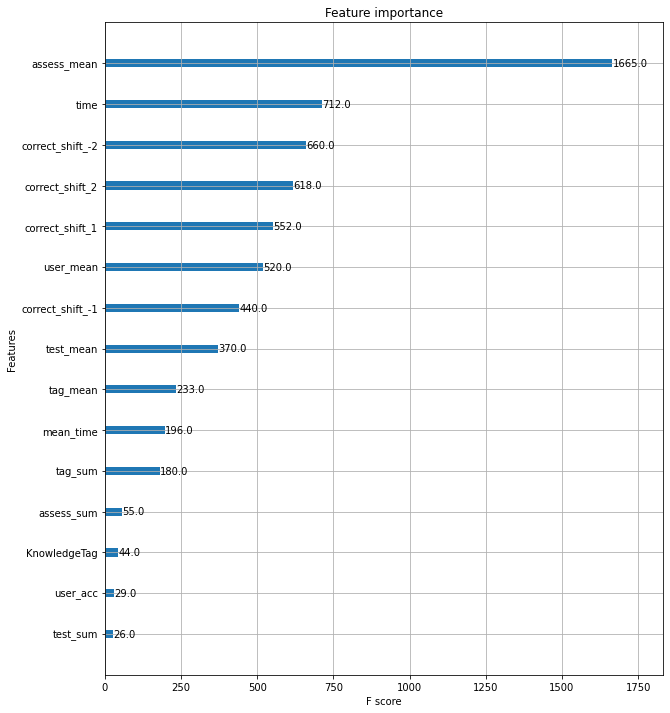

In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## 5. Inference

In [11]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=["Timestamp"])

# FEATURE ENGINEERING
test_df = get_features(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
y_test_df = test_df['answerCode']

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

xgb_test_df = xgb.DMatrix(data=test_df[FEATS] , label=y_test_df)

In [12]:
# MAKE PREDICTION
total_preds = xgb_model.predict(xgb_test_df)

In [13]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "xgboost.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/xgboost.csv
